# 와인 품질 분류 모델

##목차

- 첫번째 시도 (0.5 정도 성능)
- 두번째 시도 (0.7 까지 성능 향상 )
- 선형 회귀 방법
- 결론

## 공통 사항 (라이브러리, 데이터 처리)

###라이브러리 설치

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from matplotlib import pyplot

from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

### 데이터 처리

In [3]:
!pwd
!ls -al
!head train.csv
!head test.csv

/content
total 500
drwxr-xr-x 1 root root   4096 Aug 30 08:20 .
drwxr-xr-x 1 root root   4096 Aug 30 08:14 ..
drwxr-xr-x 4 root root   4096 Aug 25 13:35 .config
drwxr-xr-x 1 root root   4096 Aug 25 13:35 sample_data
-rw-r--r-- 1 root root  73676 Aug 30 08:20 test.csv
-rw-r--r-- 1 root root 418941 Aug 30 08:20 train.csv
index,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,5,5.6,0.695,0.06,6.8,0.042,9.0,84.0,0.9943200000000001,3.44,0.44,10.2,white
1,5,8.8,0.61,0.14,2.4,0.067,10.0,42.0,0.9969,3.19,0.59,9.5,red
2,5,7.9,0.21,0.39,2.0,0.057,21.0,138.0,0.9917600000000001,3.05,0.52,10.9,white
3,6,7.0,0.21,0.31,6.0,0.046,29.0,108.0,0.9939,3.26,0.5,10.8,white
4,6,7.8,0.4,0.26,9.5,0.059000000000000004,32.0,178.0,0.9955,3.04,0.43,10.9,white
5,6,6.0,0.19,0.37,9.7,0.032,17.0,50.0,0.9932,3.08,0.66,12.0,white
6,5,6.1,0.22,0.49,1.5,0.051,18.0,87.0,0.9928,3.3,0.46,9.6,white
7,6,7.1,0.38,0.42,11.8,0.

content 파일 내부에  test.csv, rain.csv 데이터를 넣고, 정상적으로 잘 들어갔는지 확인한다.

In [4]:
train_wine = pd.read_csv("train.csv")
test_wine = pd.read_csv("test.csv")

csv 파일을 불러와 각각 train_wine, test_wine로 저장한다.

In [5]:
train_data = train_wine.to_numpy()
test_data = test_wine.to_numpy()

Data Frame 형의 train_wine과 test_wine을 numpy로 변환한다.

## 첫번째 시도

### type 라벨 숫자변환

In [6]:
for i in range(len(train_data)):
  if train_data[i][13] == "red":
    train_data[i][13] = 1
  else:
    train_data[i][13] = 2

for i in range(len(test_data)):
  if test_data[i][12] == "red":
    test_data[i][12] = 1
  else:
    test_data[i][12] = 2

train_data, test_data의 type 라벨의 값들을 문자열 상태로는 사용할 수 없기 때문에 각 문자열에 값을 매겨 주었다.

 - "red" 는 1
 - "white" 는 2

In [7]:
train_data = train_data.astype(float)
test_data = test_data.astype(float)

model.fit 과정에서, 아래와 같은 에러가 발생하여 위와 같이 처리했다.

 - Error : Failed to convert a NumPy array to a Tensor (Unsupported object type float).

### 학습을 위한 data 분리

In [8]:
index = 4000

train_x = train_data[:index, 2:14]
train_y = train_data[:index, 1:2]

test_x = train_data[index:, 2:14]
test_y = train_data[index:, 1:2]

test = test_data[:, 1:]
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)
print(test.shape)

(4000, 12)
(4000, 1)
(1497, 12)
(1497, 1)
(1000, 12)


### 모델 정의

train_data 내에서 모델을 학습시키기 위한 데이터와 테스틀를 하기 위한 데이터로 나누었다.

In [9]:
from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback

class PlotLosses(Callback):

  def on_train_begin(self, logs={}):

    self.i = 0
    self.x = []
    self.losses = []
    self.val_losses = []

    self.fig = plt.figure()

    self.logs = []


  def on_epoch_end(self, epoch, logs={}):

    self.logs.append(logs)
    self.x.append(self.i)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))
    self.i += 1

    clear_output(wait=True)
    plt.plot(self.x, self.losses, label="loss")
    plt.plot(self.x, self.val_losses, label="val_loss")
    plt.legend()
    plt.show();
    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])

Loss를 실시간으로 출력하기 위한 클래스 PlotLosses를 정의하였다.

In [10]:
model = keras.Sequential([
    keras.layers.Dense(32, activation='relu', input_shape=(12,)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [11]:
model.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                416       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_6 (Dense)              (None, 16)                2

학습시킬 모델을 정의하였다.

input node의 개수 는 train_data의 label 개수인 12개이고 output node의 개수는 1~10 까지의 qulity 값으로 총 10개이다.

### 학습 결과

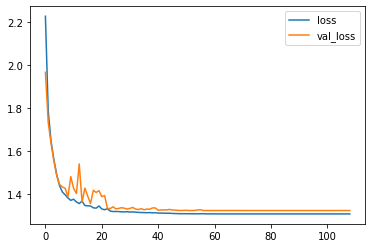

loss =  1.3073679208755493 , val_loss =  1.3231768608093262
Epoch 00109: early stopping


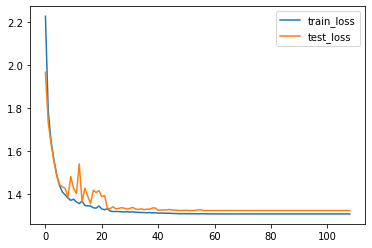

In [12]:
model_check_point = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
plot_losses = PlotLosses()
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_learning_rate=0.01)

callbacks = [model_check_point, plot_losses, reduce_lr, early_stopping]

history = model.fit(train_x, train_y, validation_split = 0.1,batch_size=256, epochs=1000, verbose=1, callbacks=callbacks)

pyplot.plot(history.history['loss'], label='train_loss')
pyplot.plot(history.history['val_loss'], label='test_loss')
pyplot.legend()
pyplot.show()

Loss 실시간 출력, 학습률 조정, early stopping, 모델 저장 기능을 하는 callback들을 모두 담아 model을 학습시켰다.

Loss와 validation loss의 변화를 실시간으로 확인할 수 있다.

In [13]:
loss, acc = model.evaluate(test_x, test_y)
print("loss=", loss)
print("acc=", acc)

47/47 [==============================] - 0s 1ms/step - loss: 1.2755 - accuracy: 0.4476
loss= 1.2754597663879395
acc= 0.4475618004798889


test_x와 test_y 데이터를 사용하여 모델의 loss와 accuracy를 측정한다.

In [14]:
y_ = model.predict(test)
print(y_)
print(np.argmax(y_, axis = 1))

[[2.5189314e-03 2.3661353e-04 1.2007235e-03 ... 1.8729506e-01
  5.6224152e-02 2.4658167e-03]
 [5.3804717e-03 9.5000770e-04 2.2364340e-03 ... 1.8007632e-01
  4.9561545e-02 6.5341415e-03]
 [2.7359012e-05 1.8538391e-07 7.4337559e-06 ... 1.4065616e-01
  2.0670090e-02 2.1676926e-05]
 ...
 [1.7408613e-02 5.8093444e-03 9.8049054e-03 ... 1.8307981e-01
  7.0796490e-02 2.0298215e-02]
 [8.6234873e-03 1.9356264e-03 4.0266481e-03 ... 1.8361025e-01
  5.8074098e-02 1.0291666e-02]
 [5.0163839e-05 6.1192213e-07 1.1553770e-05 ... 1.3495494e-01
  1.7037231e-02 4.9672737e-05]]
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 

학습된 모델을 바탕으로 test 데이터를 넣어 모델이 예측하는 각 와인의 등급을 확인할 수 있다.

첫번째 시도 결과
 - 레이어 개수, 노드 개수, 모델 fit 특성 등 다양하게 바꾸어 가며 시도해봤지만 유의마한 차이가 없었고, 0.5 이상의 성능을 얻기 어려웠다.
 - test 예측 결과가 대부분 5,6 등급으로 나와,
   5~7 사이의 와인들일 것이라고 추측할 수 있지만 모델의 성능이 낮아 신뢰할 수 없다.

## 두번째 시도

### type 라벨 숫자 변환 및 quality 라벨 분류

In [15]:
y = []

for i in range(len(train_data)):
  if train_data[i][1] <= 5:
    y.append(0)
  elif train_data[i][1] <= 7:
    y.append(1)
  else:
    y.append(2)
  if train_data[i][13] == "red":
    train_data[i][13] = 1
  else:
    train_data[i][13] = 2

y = np.array(y)

for i in range(len(test_data)):
  if test_data[i][12] == "red":
    test_data[i][12] = 1
  else:
    test_data[i][12] = 2

train_data의 quality 라벨의 값들를 범위에 따라 등급을 매기기로 했다.

- 품질 3 ~ 5 는 0
- 품질 6 ~ 7 은 1
- 품질 8 ~ 은 2
또한 train_data의 type 라벨의 값들을 문자열 상태로는 사용할 수 없기 때문에 각 문자열에 값을 매겨 주었다.

- "red" 는 1
- "white" 는 2

이후 학습 과정들은 첫번째 시도와 크게 다르지 않다.

In [16]:
train_data = train_data.astype(float)
test_data = test_data.astype(float)

In [17]:
index = 4500

train_x = train_data[:index, 2:14]
train_y = y[:index]

test_x = train_data[index:, 2:14]
test_y = y[index:]
test = test_data[:, 1:]

###모델 정의

In [18]:
from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback

class PlotLosses(Callback):

  def on_train_begin(self, logs={}):

    self.i = 0
    self.x = []
    self.losses = []
    self.val_losses = []

    self.fig = plt.figure()

    self.logs = []


  def on_epoch_end(self, epoch, logs={}):

    self.logs.append(logs)
    self.x.append(self.i)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))
    self.i += 1

    clear_output(wait=True)
    plt.plot(self.x, self.losses, label="loss")
    plt.plot(self.x, self.val_losses, label="val_loss")
    plt.legend()
    plt.show();
    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])

학습시킬 모델을 정의하였다.

input node의 개수는 train_data의 label 개수인 12개이고,

 output node의 개수는 앞서 품질의 등급을 매긴 세 등급을 따라 3개이다.

In [19]:
model = keras.Sequential([
    keras.layers.Dense(15, activation='relu', input_shape=(12,)),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])

In [20]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 15)                195       
_________________________________________________________________
dense_12 (Dense)             (None, 15)                240       
_________________________________________________________________
dense_13 (Dense)             (None, 15)                240       
_________________________________________________________________
dense_14 (Dense)             (None, 15)                240       
_________________________________________________________________
dense_15 (Dense)             (None, 15)                240       
_________________________________________________________________
dense_16 (Dense)             (None, 15)                240       
_________________________________________________________________
dense_17 (Dense)             (None, 15)               

### 학습 결과

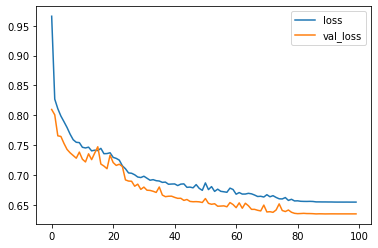

loss =  0.6545803546905518 , val_loss =  0.6348679065704346


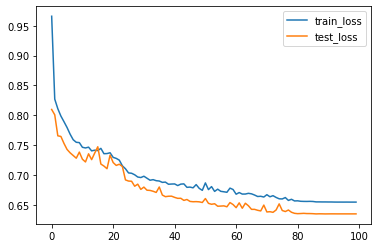

In [21]:
model_check_point = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
plot_losses = PlotLosses()
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_learning_rate=0.001)

callbacks = [model_check_point, plot_losses, reduce_lr, early_stopping]

history = model.fit(train_x, train_y, validation_split = 0.2, batch_size = 100, epochs=100, verbose=1, callbacks=callbacks)

pyplot.plot(history.history['loss'], label='train_loss',)
pyplot.plot(history.history['val_loss'], label='test_loss')
pyplot.legend()
pyplot.show()

In [22]:
loss, acc = model.evaluate(test_x, test_y)
print("loss=", loss)
print("acc=", acc)

32/32 [==============================] - 0s 2ms/step - loss: 0.6317 - accuracy: 0.6991
loss= 0.6316690444946289
acc= 0.6990972757339478


est_x와 test_y 데이터를 사용하여 모델의 loss와 accuracy를 측정한다.

In [23]:
y_ = model.predict(test)
print(y_)
print(np.argmax(y_, axis = 1))

[[0.60368866 0.38923532 0.00707606]
 [0.7193651  0.2768281  0.00380673]
 [0.56719965 0.42001876 0.01278153]
 ...
 [0.6052934  0.38654903 0.00815758]
 [0.24192505 0.7472803  0.01079462]
 [0.4092553  0.5603943  0.03035043]]
[0 0 0 1 1 0 1 0 1 1 0 0 1 1 1 0 1 1 0 0 1 1 0 1 1 0 1 0 0 0 1 1 1 0 0 1 0
 1 1 0 1 0 1 1 1 1 1 1 0 0 0 0 1 0 0 0 1 0 1 1 1 1 0 1 1 0 0 0 1 0 1 0 0 0
 1 0 0 1 1 1 1 1 0 0 1 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 0 1 0 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0 0 0 1 1 0 1 0 0 0 1 1 0 0 0 1 1
 1 1 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 0 0 0 1 0 1 1 0 1 0 0 0 0 0 1 0
 1 1 1 0 1 1 1 0 1 1 1 1 0 0 0 1 0 1 0 0 1 1 1 1 1 1 0 0 0 0 1 0 1 1 1 1 1
 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 0 0 1 1 1 0 1 1 1
 0 1 0 0 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0 0 0 0 1 0 1
 0 1 0 1 1 1 0 1 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 0 1 1 1 0 1 1
 1 0 1 0 1 1 1 1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 1 1 1 1 0 0 0 1 1 1 0 0 1 0
 1 0 0 1 0 0 0 0 1 1 1 1 1 1

학습된 모델을 바탕으로 test 데이터를 넣어 모델이 예측하는 각 와인의 등급을 확인할 수 있다.

두번째 시도 결과

- 첫번째 시도에 비해 정확도가 0.2 이상 증가하여 성능이 많이 개선되었다.
- 첫번째 시도에서 loss가 약 1.25로 나온 반면에 두번째 시도에서 약 0.63이 나와 loss 측면에서도 기능이 개선된 것을 확인할 수 있었다.
- 추후 알고리즘을 개선하여, 구체적인 품질값을 얻을 수 있으면 더 좋을 것이다.

## 선형회귀 모델 (추가적 시도)

위의 시도들과 같은 방법으로 데이터를 처리하였다.

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from matplotlib import pyplot

from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [25]:
!ls -al
!head train.csv

total 624
drwxr-xr-x 1 root root   4096 Aug 30 08:20 .
drwxr-xr-x 1 root root   4096 Aug 30 08:14 ..
-rw-r--r-- 1 root root 126584 Aug 30 08:22 best_model.h5
drwxr-xr-x 4 root root   4096 Aug 25 13:35 .config
drwxr-xr-x 1 root root   4096 Aug 25 13:35 sample_data
-rw-r--r-- 1 root root  73676 Aug 30 08:20 test.csv
-rw-r--r-- 1 root root 418941 Aug 30 08:20 train.csv
index,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,5,5.6,0.695,0.06,6.8,0.042,9.0,84.0,0.9943200000000001,3.44,0.44,10.2,white
1,5,8.8,0.61,0.14,2.4,0.067,10.0,42.0,0.9969,3.19,0.59,9.5,red
2,5,7.9,0.21,0.39,2.0,0.057,21.0,138.0,0.9917600000000001,3.05,0.52,10.9,white
3,6,7.0,0.21,0.31,6.0,0.046,29.0,108.0,0.9939,3.26,0.5,10.8,white
4,6,7.8,0.4,0.26,9.5,0.059000000000000004,32.0,178.0,0.9955,3.04,0.43,10.9,white
5,6,6.0,0.19,0.37,9.7,0.032,17.0,50.0,0.9932,3.08,0.66,12.0,white
6,5,6.1,0.22,0.49,1.5,0.051,18.0,87.0,0.9

In [26]:
train_wine = pd.read_csv("train.csv")
test_wine = pd.read_csv("test.csv")

In [27]:
train_data = train_wine.to_numpy()
test_data = test_wine.to_numpy()

In [28]:
for i in range(len(train_data)):
  if train_data[i][13] == "red":
    train_data[i][13] = 1
  else:
    train_data[i][13] = 2

for i in range(len(test_data)):
  if test_data[i][12] == "red":
    test_data[i][12] = 1
  else:
    test_data[i][12] = 2


In [29]:
train_data = train_data.astype(float)
test_data = test_data.astype(float)

선형회귀 모델을 위해 필요한 클래스를 import하고, 데이터를 준비했다.  

In [30]:
from pandas.core.common import random_state
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

X = train_x = train_data[:, 2:14]
y = train_y = train_data[:, 1]

Y = test_data[:,1:]


print(X.shape)
print(y.shape)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(Y.shape)


(5497, 12)
(5497,)
(4122, 12)
(1375, 12)
(4122,)
(1375,)
(1000, 12)


학습을 통해, 다중 선형 회귀 방정식의 parameter값들을 얻을 수 있었다.





In [31]:
model.fit(X_train,y_train)

print(model.coef_)

[ 1.10212217e-01 -1.47446274e+00 -1.88706537e-01  7.13009442e-02
 -4.73576989e-01  3.27513948e-03 -8.49978997e-04 -1.18923241e+02
  5.68056375e-01  8.69070719e-01  2.16023631e-01 -3.67773171e-01]


학습된 모델에 test data Y를 넣어주었다.

In [32]:
y_pred = model.predict(Y)

예측된 qulity 값을 반올림하여 정수 등급으로 만들었다.

In [33]:
from tensorflow.python.keras.layers.core import Reshape
def roundhalf(i):
    val = i - int(i)
    if val >= 0.5:
        return int(i) + 1
    else:
        return int(i)

for i in range(len(y_pred)):
    y_pred[i] = roundhalf(y_pred[i])

import numpy as np

target = np.reshape(y_pred,(1000,))

In [34]:
print(target)
print(target.shape)

[6. 5. 6. 6. 6. 6. 6. 6. 6. 6. 6. 5. 6. 6. 6. 5. 6. 7. 6. 5. 6. 6. 5. 6.
 6. 5. 5. 5. 6. 5. 7. 6. 5. 5. 6. 6. 5. 5. 6. 6. 6. 6. 6. 6. 6. 7. 5. 6.
 5. 6. 5. 5. 6. 5. 5. 6. 6. 5. 5. 6. 5. 6. 6. 6. 6. 6. 5. 5. 6. 5. 6. 5.
 6. 5. 6. 5. 6. 6. 6. 6. 6. 6. 5. 5. 7. 6. 6. 5. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 5. 5. 6. 5. 5. 6. 6. 6. 6. 6. 6. 6. 6. 6. 5. 6. 5. 7. 6. 6.
 7. 5. 6. 6. 6. 5. 6. 6. 6. 6. 5. 5. 6. 5. 6. 7. 6. 6. 5. 5. 5. 5. 6. 5.
 5. 5. 6. 5. 7. 6. 6. 7. 6. 5. 6. 5. 6. 6. 6. 5. 5. 6. 6. 6. 6. 5. 5. 6.
 6. 5. 5. 5. 6. 5. 6. 5. 6. 5. 6. 5. 6. 5. 5. 7. 5. 6. 6. 6. 6. 6. 6. 5.
 6. 6. 6. 6. 7. 5. 6. 6. 6. 6. 5. 5. 6. 5. 6. 6. 6. 6. 7. 5. 5. 6. 6. 6.
 6. 5. 6. 6. 6. 6. 6. 6. 7. 5. 6. 5. 6. 5. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 7. 5. 7. 6. 6. 7. 7. 7. 6. 6. 7. 7. 6. 6. 5. 5. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 5. 5. 6. 6. 6. 6. 5. 5. 6. 6. 6. 6. 6. 6. 6. 6.
 5. 6. 6. 5. 5. 6. 5. 6. 6. 6. 5. 7. 6. 6. 5. 5. 6. 6. 5. 7. 5. 5. 6. 5.
 6. 6. 6. 6. 5. 5. 6. 6. 5. 5. 6. 5. 5. 5. 5. 6. 7.

선형 회귀 방법으로 얻은 값을 두번째 시도와 비교하기 위해 0~2 사이 값으로 변환하였다.

In [35]:
def classify(n):
  if n <= 5:
    return 0
  elif n <= 7:
    return 1
  else:
    return 2

target = list(map(classify, target))
target = np.asarray(target)
print(target)

[1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 0 1 1 0 0 0 1 0 1 1 0 0 1 1 0
 0 1 1 1 1 1 1 1 1 0 1 0 1 0 0 1 0 0 1 1 0 0 1 0 1 1 1 1 1 0 0 1 0 1 0 1 0
 1 0 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1
 1 1 1 0 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 0 0 1 0 1 1 1 1 0 0 0 0 1 0 0 0 1 0
 1 1 1 1 1 0 1 0 1 1 1 0 0 1 1 1 1 0 0 1 1 0 0 0 1 0 1 0 1 0 1 0 1 0 0 1 0
 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1
 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 0 0 1 0 1
 1 1 0 1 1 1 0 0 1 1 0 1 0 0 1 0 1 1 1 1 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 1 1
 0 0 1 0 1 1 0 1 1 1 1 0 1 1 1 0 1 0 0 0 1 1 0 1 1 1 1 0 1 0 1 1 1 1 0 1 1
 1 0 0 1 0 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 0
 1 1 0 1 0 0 0 0 1 1 1 1 0 1 1 0 1 1 1 1 0 0 1 1 1 0 1 1 0 1 0 0 0 0 1 1 1
 1 1 0 0 0 1 1 1 0 1 1 0 1 1 1 0 1 1 1 0 0 0 1 1 1 0 0 0 0 1 0 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 